In [1]:
from glob import glob
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
all_file_path = glob('dataverse_files/*.edf')
print(len(all_file_path))

28


In [3]:
healthy_fp = [i for i in all_file_path if 'h' in i.split('\\')[1]]
patient_fp = [i for i in all_file_path if 's' in i.split('\\')[1]]
print(len(healthy_fp), len(patient_fp))

14 14


In [4]:
def read_data(fp):
    data = mne.io.read_raw_edf(fp, preload = True)
    data.set_eeg_reference()
    data.filter(l_freq = 0.5, h_freq = 45)
    epochs = mne.make_fixed_length_epochs(data, duration = 5, overlap = 1)
    array = epochs.get_data()
    return array

In [18]:
sample_data = read_data(healthy_fp[0])

Extracting EDF parameters from D:\NITR Summer 24\CNN T1\dataverse_files\h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
231 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 231 events and 1250 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


In [19]:
sample_data.shape #no. of epochs, channels, length of signal

(231, 19, 1250)

In [5]:
%%capture
healthy_epochs_arr = [read_data(i) for i in healthy_fp]
patient_epochs_arr = [read_data(i) for i in patient_fp]

In [6]:
healthy_epochs_arr[0].shape, healthy_epochs_arr[1].shape

((231, 19, 1250), (227, 19, 1250))

In [7]:
# Make labels
healthy_epochs_labels = [len(i)*[0] for i in healthy_epochs_arr]
patient_epochs_labels = [len(i)*[1] for i in patient_epochs_arr]
len(healthy_epochs_labels), len(patient_epochs_labels)

(14, 14)

In [8]:
# To combine
data_list = healthy_epochs_arr + patient_epochs_arr
label_list = healthy_epochs_labels + patient_epochs_labels

In [9]:
group_list = [[i]*len(j) for i, j in enumerate(data_list)]
len(group_list)

28

In [10]:
data_array = np.vstack(data_list)
label_array = np.hstack(label_list)
group_array = np.hstack(group_list)
print(data_array.shape, label_array.shape, group_array.shape)

(7201, 19, 1250) (7201,) (7201,)


#### Extracting Featuere

In [19]:
# for 1 feature, shape = (7201, 19)
# for n feature, shape = (7201, 19) * n

In [11]:
np.mean(data_array, axis = -1).shape

(7201, 19)

In [12]:
from scipy import stats
def mean(x):
    return np.mean(x, axis=-1)
def std(x):
    return np.std(x, axis=-1)
def ptp(x):
    return np.ptp(x, axis=-1)
def var(x):
    return np.var(x, axis=-1)
def minim(x):
    return np.min(x, axis=-1)
def maxim(x):
    return np.max(x, axis=-1)
def argminim(x):              
    return np.argmin(x,axis=-1)
def argmaxim(x):              
    return np.argmax(x,axis=-1)
def rms(x):                   
    return np.sqrt(np.mean(x**2,axis=-1))
def abs_diff_signal(x):       
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1)
def skewness(x):              
    return stats.skew(x,axis=-1)
def kurtosis(x):              
    return stats.kurtosis(x,axis=-1)
def concatenate_features(x):  
    return np.concatenate ((mean(x), std(x), ptp(x), var(x), minim(x), maxim(x), 
                            argminim(x), argmaxim(x), rms(x), abs_diff_signal(x), 
                            skewness (x), kurtosis(x)), axis=-1)

In [13]:
features = []
for d in data_array:
    features.append(concatenate_features(d))

In [14]:
features_array = np.array(features)
features_array.shape

(7201, 228)

In [32]:
228/19 # number of features used for classification

12.0

In [33]:
####

In [15]:
data_array.shape

(7201, 19, 1250)

In [16]:
data_array = np.moveaxis(data_array, 2, 1)
data_array.shape

(7201, 1250, 19)

In [21]:
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
def cnnmodel():
    clear_session()
    model=Sequential()
    model.add(Conv1D(filters=5,kernel_size=3,strides=1,input_shape=(6250,19)))#1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#2
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#4
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#6
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#8
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D())#10
    model.add(Dense(1,activation='sigmoid'))#11
    
    model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model=cnnmodel()
model.summary()

C:\Users\KIIT\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 6248, 5)             │             290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6248, 5)             │              20 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 6248, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 3124, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3122, 5)             │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 3122, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1561, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1561, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1559, 5)             │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 1559, 5)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 779, 5)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 779, 5)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 777, 5)              │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 777, 5)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_1                  │ (None, 388, 5)              │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 386, 5)              │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 386, 5)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 5)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 636 (2.48 KB)

 Trainable params: 626 (2.45 KB)

 Non-trainable params: 10 (40.00 B)

In [22]:
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf = GroupKFold()

In [23]:
accuracy = []
for train_index, val_index in gkf.split(data_array, label_array, groups = group_array):
    train_features, train_labels = data_array[train_index], label_array[train_index]
    val_features, val_labels = data_array[val_index], label_array[val_index]
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, \
                            train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, \
                            val_features.shape[-1])).reshape(val_features.shape)
    model = cnnmodel()
    model.fit(train_features, train_labels, epochs = 15, batch_size = 400, 
              validation_data = (val_features, val_labels))
    accuracy.append(model.evaluate(val_features, val_labels)[1])
    # X_test = train_features, Y_test = train_labels
    # x_pred = val_features, y_pred = val_labels

C:\Users\KIIT\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5924 - loss: 0.6731 - val_accuracy: 0.3720 - val_loss: 0.7256
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5917 - loss: 0.6659 - val_accuracy: 0.3720 - val_loss: 0.7164
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5954 - loss: 0.6569 - val_accuracy: 0.3720 - val_loss: 0.7084
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5919 - loss: 0.6544 - val_accuracy: 0.3727 - val_loss: 0.6965
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5982 - loss: 0.6436 - val_accuracy: 0.3734 - val_loss: 0.6788
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6046 - loss: 0.6335 - val_accuracy: 0.4399 - val_loss: 0.6549
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5898 - loss: 0.6307 - val_accuracy: 0.6122 - val_loss: 0.6368
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6031 - loss: 0.6262 - val_accuracy: 0.7152 - 

C:\Users\KIIT\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.4878 - loss: 0.6927 - val_accuracy: 0.5376 - val_loss: 0.6793
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5533 - loss: 0.6790 - val_accuracy: 0.5376 - val_loss: 0.6745
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5563 - loss: 0.6710 - val_accuracy: 0.5376 - val_loss: 0.6747
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5496 - loss: 0.6643 - val_accuracy: 0.5376 - val_loss: 0.6764
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5531 - loss: 0.6509 - val_accuracy: 0.5457 - val_loss: 0.6824
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5582 - loss: 0.6314 - val_accuracy: 0.5823 - val_loss: 0.6961
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6145 - loss: 0.6115 - val_accuracy: 0.4848 - val_loss: 0.7183
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7279 - loss: 0.5778 - val_accuracy: 0.4821 - 

C:\Users\KIIT\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5417 - loss: 0.6781 - val_accuracy: 0.6066 - val_loss: 0.6690
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5280 - loss: 0.6738 - val_accuracy: 0.6066 - val_loss: 0.6672
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5375 - loss: 0.6606 - val_accuracy: 0.6012 - val_loss: 0.6680
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5630 - loss: 0.6491 - val_accuracy: 0.6832 - val_loss: 0.6667
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6000 - loss: 0.6405 - val_accuracy: 0.6515 - val_loss: 0.6684
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6232 - loss: 0.6256 - val_accuracy: 0.6638 - val_loss: 0.6624
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6733 - loss: 0.6118 - val_accuracy: 0.6862 - val_loss: 0.6623
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7019 - loss: 0.5999 - val_accuracy: 0.6978 - 

C:\Users\KIIT\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.4708 - loss: 0.6982 - val_accuracy: 0.5353 - val_loss: 0.6927
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5482 - loss: 0.6806 - val_accuracy: 0.5353 - val_loss: 0.6969
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5559 - loss: 0.6702 - val_accuracy: 0.5353 - val_loss: 0.6997
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5627 - loss: 0.6590 - val_accuracy: 0.5353 - val_loss: 0.6959
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5476 - loss: 0.6567 - val_accuracy: 0.5346 - val_loss: 0.6941
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5629 - loss: 0.6399 - val_accuracy: 0.5535 - val_loss: 0.6912
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5726 - loss: 0.6288 - val_accuracy: 0.5669 - val_loss: 0.6880
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6420 - loss: 0.6121 - val_accuracy: 0.5783 - 

C:\Users\KIIT\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.5143 - loss: 0.6868 - val_accuracy: 0.6952 - val_loss: 0.6719
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5056 - loss: 0.6817 - val_accuracy: 0.6958 - val_loss: 0.6671
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5122 - loss: 0.6729 - val_accuracy: 0.6945 - val_loss: 0.6692
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5254 - loss: 0.6671 - val_accuracy: 0.7732 - val_loss: 0.6753
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5300 - loss: 0.6507 - val_accuracy: 0.5680 - val_loss: 0.6844
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5964 - loss: 0.6380 - val_accuracy: 0.4448 - val_loss: 0.6937
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6603 - loss: 0.6228 - val_accuracy: 0.3883 - val_loss: 0.7021
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6740 - loss: 0.6048 - val_accuracy: 0.3405 - 

In [24]:
accr = np.mean(accuracy) * 100
print("Accuracy = ", accr)

Accuracy =  71.58801436424255


In [29]:
from sklearn.metrics import classification_report
val_labels = np.around(model.predict(train_features))
rep = classification_report(train_labels, val_labels)
print(rep)

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      2798
           1       0.85      0.95      0.90      2917

    accuracy                           0.89      5715
   macro avg       0.89      0.89      0.89      5715
weighted avg       0.89      0.89      0.89      5715



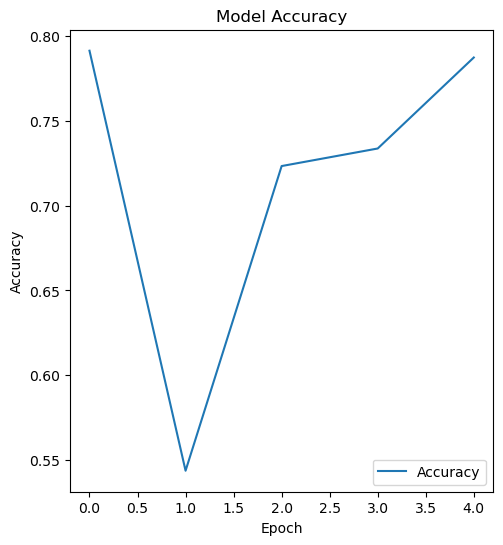

In [31]:
# Plotting both the accuracy and loss
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()